In [10]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils

In [11]:
train_root  = "dataset2-master/images/TRAIN"
test_root = "dataset2-master/images/TEST"

In [12]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,160)

In [13]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

def load_data(root):

    datasets = [root]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    n = 0
    for i in range(4):
        for j in range(5):
            plt.subplot(4,5,i*5+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            while labels[n]!=i:
                n = n + 1
            plt.imshow(images[n], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[n]])
            n = n + 1


In [15]:
images, labels = load_data(train_root)

100%|█████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:12<00:00, 196.95it/s]


In [16]:
test_images, test_labels = load_data(test_root)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 282.36it/s]


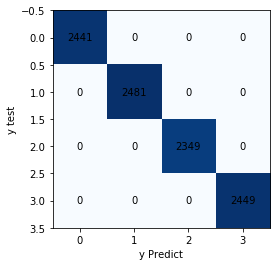

In [17]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(labels, labels)
# Plot confusion matrix
plt.imshow(cm2,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm2):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [19]:
images, labels = shuffle(images, labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [20]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2)

In [21]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [26]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(7776, 160, 120, 3)
(7776,)
(1944, 160, 120, 3)
(1944,)


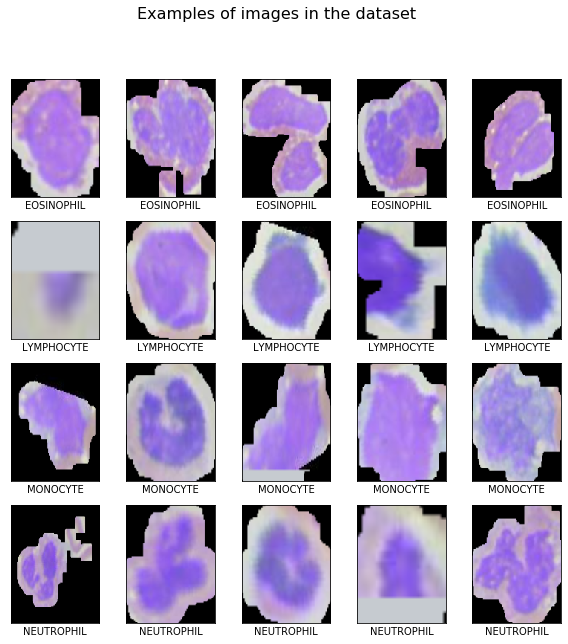

In [27]:
display_examples(class_names, train_images, train_labels)

Resnet

In [28]:
# Using Resnet
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(160,120,3))
restnet.summary()

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model2 = Sequential()
model2.add(restnet)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation='softmax'))



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 126, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 60, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 40, 30, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 40, 30, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 40, 30, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 40, 30, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 20, 15, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 20, 15, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 20, 15, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 20, 15, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 10, 8, 256)   590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 8, 256)  1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 8, 256)  0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 10, 8, 1024)  263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 10, 8, 256)  0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 10, 8, 1024)  263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 10, 8, 1024)  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 10, 8, 1024)  0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 5, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 5, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 5, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 5, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [30]:
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

model2.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
history2 = model2.fit(train_images, train_labels, batch_size = 32, epochs = 15, validation_data=(val_images, val_labels))

Epoch 1/15
243/243 [==============================] - 683s 3s/step - loss: 1.1544 - accuracy: 0.7067 - val_loss: 3.5389 - val_accuracy: 0.2510
Epoch 2/15
243/243 [==============================] - 680s 3s/step - loss: 0.5275 - accuracy: 0.8412 - val_loss: 2.8025 - val_accuracy: 0.3416
Epoch 3/15
243/243 [==============================] - 624s 3s/step - loss: 0.4576 - accuracy: 0.8717 - val_loss: 6.7091 - val_accuracy: 0.2515
Epoch 4/15
243/243 [==============================] - 611s 3s/step - loss: 0.4209 - accuracy: 0.8493 - val_loss: 1.2687 - val_accuracy: 0.6533
Epoch 5/15
243/243 [==============================] - 614s 3s/step - loss: 0.2920 - accuracy: 0.8885 - val_loss: 1.0999 - val_accuracy: 0.6451
Epoch 6/15
243/243 [==============================] - 692s 3s/step - loss: 0.2965 - accuracy: 0.8886 - val_loss: 1.4129 - val_accuracy: 0.5514
Epoch 7/15
243/243 [==============================] - 711s 3s/step - loss: 0.2756 - accuracy: 0.8846 - val_loss: 1.9116 - val_accuracy: 0.5947

In [31]:
score2 = model2.evaluate(test_images,test_labels)
print(score2)

76/76 [==============================] - 48s 633ms/step - loss: 1.3836 - accuracy: 0.3075
[1.3836495876312256, 0.30750206112861633]


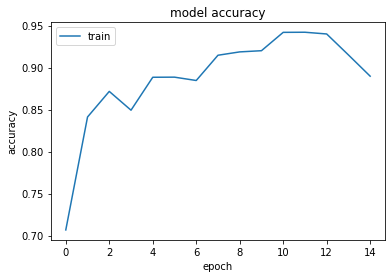

In [32]:
plt.plot(history2.history['accuracy'])
# #plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


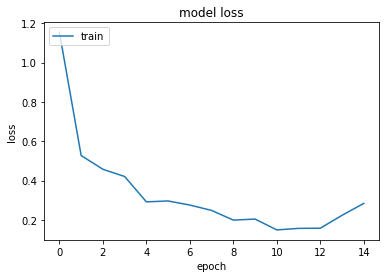

In [33]:
plt.plot(history2.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

76/76 [==============================] - 49s 617ms/step


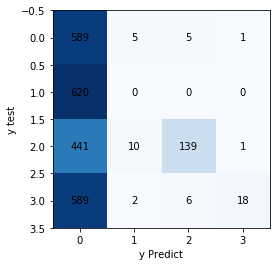

In [34]:
from sklearn.metrics import confusion_matrix
pred2 = np.argmax(model2.predict(test_images),axis=1)
cm2 = confusion_matrix(test_labels, pred2)
# Plot confusion matrix
plt.imshow(cm2,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm2):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

243/243 [==============================] - 160s 660ms/step


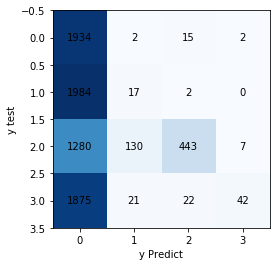

In [36]:
from sklearn.metrics import confusion_matrix
pred2 = np.argmax(model2.predict(train_images),axis=1)
cm2 = confusion_matrix(train_labels, pred2)
# Plot confusion matrix
plt.imshow(cm2,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm2):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()